In [1]:
# import necessary packages and libraries 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  # Corrected this line
import xarray as xr
import numpy as np
import os 
from datetime import datetime

In [2]:
# --- Configuration ---

# New ratio to convert GLDAS data from kg/m^2 to cm
KG_M2_TO_CM_RATIO = 0.1

# Input the file path to your main data directory
# Using r'' is a safer way to write Windows paths
BASE_DIR = r'D:\Groundwater Vulnerability Mapping\data'

# Default figure size for plots
FIG_SIZE = (10, 10)

In [3]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

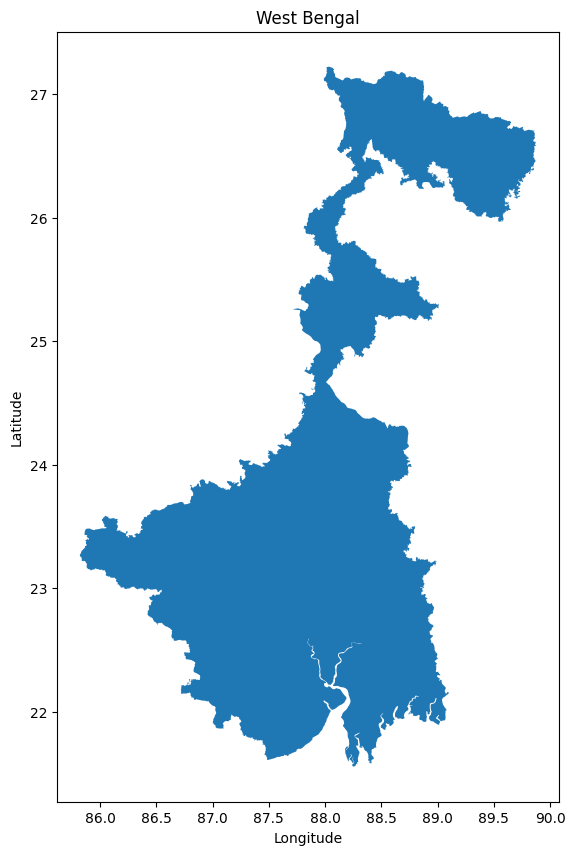

In [4]:
# Read the shapefile
basin_shapefile = gpd.read_file(os.path.join(BASE_DIR, r'shapefiles\West Bengal\West_Bengal.shp'))

# Reproject to standard latitude-longitude (WGS84)
basin_shapefile = basin_shapefile.to_crs(epsg=4326)

# Plot of entire West Bengal
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
add_labels(ax, 'West Bengal')

Longitude min: 85.81970749436145
Latitude min: 21.556115085291218
Longitude max: 89.87425124571746
Latitude max: 27.221013671249814


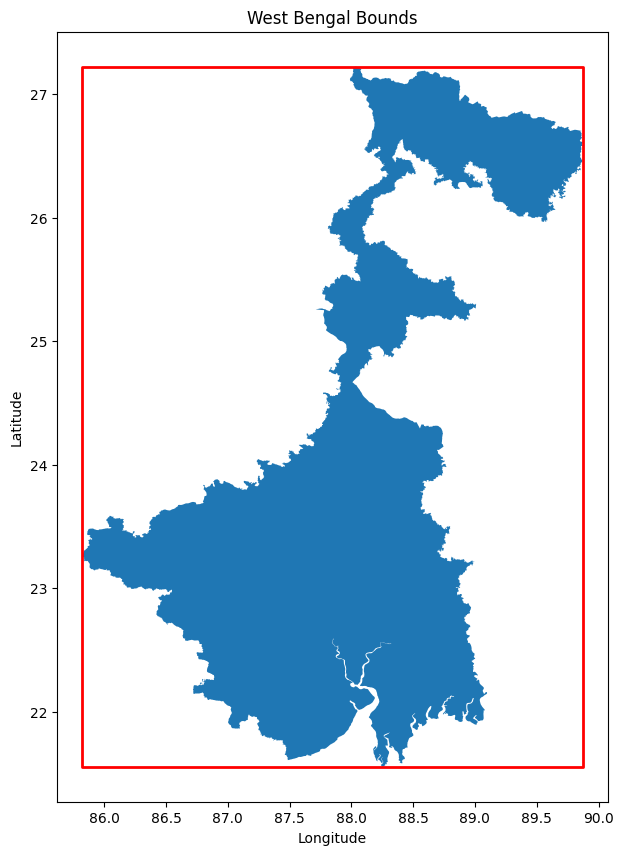

In [5]:
# Here, we use geopandas.GeoSeries.total_bounds
[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'West Bengal Bounds')
print(f"Longitude min: {lon_min}")
print(f"Latitude min: {lat_min}")
print(f"Longitude max: {lon_max}")
print(f"Latitude max: {lat_max}")

In [10]:
# Read in one file of the GLDAS data as a demonstration
# Note the interested variables "SWE_inst" and "RootMoist_inst" are measured in kilogram per square meter (kg/m2)

xr.open_dataset(r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_VIC10_M_2.1-20250814_153905\GLDAS_VIC10_M.A200001.021.nc4")

<xarray.Dataset> Size: 7MB
Dimensions:              (time: 1, bnds: 2, lon: 360, lat: 150)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2000-01-01
  * lon                  (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                  (lat) float32 600B -59.5 -58.5 -57.5 ... 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables: (12/35)
    time_bnds            (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg           (time, lat, lon) float32 216kB ...
    Lwnet_tavg           (time, lat, lon) float32 216kB ...
    Qle_tavg             (time, lat, lon) float32 216kB ...
    Qh_tavg              (time, lat, lon) float32 216kB ...
    Qg_tavg              (time, lat, lon) float32 216kB ...
    ...                   ...
    Rainf_f_tavg         (time, lat, lon) float32 216kB ...
    Tair_f_inst          (time, lat, lon) float32 216kB ...
    Qair_f_inst          (time, lat, lon) float32 216kB ...
    Psurf_f_inst         (time, lat, lon) float32 216kB ...
    SWdown_f_tavg        (time, lat, lon) float32 216kB ...
    LWdown_f_tavg        (time, lat, lon) float32 216kB ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2020-02-03T12:00:52.166
    source:                 VIC_v4.1.2 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [11]:
import pandas as pd
import xarray as xr
import os

# --- Configuration ---
gldas_path = r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_VIC10_M_2.1-20250814_153905"

# Create an empty DataFrame
gldas_df = pd.DataFrame()

# THE FIX: Define the list of your specific soil moisture layers
soil_layers = [
    'SoilMoi0_30cm_inst',
    'SoilMoi_depth2_inst',
    'SoilMoi_depth3_inst'
]

print("Starting memory-efficient GLDAS VIC data processing...")
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        file_path = os.path.join(gldas_path, filename)
        
        # 1. Reading in data
        xd = xr.open_dataset(file_path)

        # 2. Filter the xarray object FIRST
        xd_subset = xd.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

        # 3. Convert only the SMALL SUBSET to a DataFrame
        xd_df = xd_subset.to_dataframe()
        xd_df.reset_index(inplace=True)

        # 4. THE FIX: Sum your soil layers to get the total
        xd_df['TotalSoilMoisture'] = xd_df[soil_layers].sum(axis=1)

        # 5. THE FIX: Extract the correct columns, including Qs_acc and the new TotalSoilMoisture
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "Qs_acc", "TotalSoilMoisture"]]
        df_slice = df_slice.drop_duplicates()

        # Append data to the main DataFrame
        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

# THE FIX: Rename the final columns to include units
gldas_df = gldas_df.rename(columns={
    'SWE_inst': 'SWE_inst_kg/m2',
    'Qs_acc': 'Qs_acc_kg/m2',
    'TotalSoilMoisture': 'TotalSoilMoisture_kg/m2'
})

print("\n✅ GLDAS VIC data processing complete.")
print("\n--- Preview of the Final GLDAS VIC Data ---")
print(gldas_df.head())

Starting memory-efficient GLDAS VIC data processing...

✅ GLDAS VIC data processing complete.

--- Preview of the Final GLDAS VIC Data ---
        time   lon   lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  86.5  22.5        0.000000      0.003486   
1 2000-01-01  86.5  23.5        0.000000      0.004964   
2 2000-01-01  86.5  24.5        0.000004      0.003103   
3 2000-01-01  86.5  25.5        0.000000      0.000598   
4 2000-01-01  86.5  26.5        0.000017      0.000020   

   TotalSoilMoisture_kg/m2  
0               412.609802  
1               403.197174  
2               909.158936  
3               881.378967  
4               983.725037  


In [12]:
# --- Step 1: Define the correct conversion ratio ---
# Kilograms per square meter to Centimeters
KG_M2_TO_CM_RATIO = 0.1 

# --- Step 2: Convert Units from kg/m^2 to cm ---
print("Converting all GLDAS variables to depth (cm)...")

# Apply the conversion to your Total Soil Moisture column
gldas_df['TotalSoilMoisture_cm'] = gldas_df['TotalSoilMoisture_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to your Snow Water Equivalent column
gldas_df['SWE_cm'] = gldas_df['SWE_inst_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to your Runoff column
gldas_df['Qs_acc_cm'] = gldas_df['Qs_acc_kg/m2'] * KG_M2_TO_CM_RATIO

print("\n✅ Unit conversion to cm complete.")
print("\n--- Preview of Data with Centimeter Columns ---")

# Display only the key columns for a clean preview
print(gldas_df.head())

Converting all GLDAS variables to depth (cm)...

✅ Unit conversion to cm complete.

--- Preview of Data with Centimeter Columns ---
        time   lon   lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  86.5  22.5        0.000000      0.003486   
1 2000-01-01  86.5  23.5        0.000000      0.004964   
2 2000-01-01  86.5  24.5        0.000004      0.003103   
3 2000-01-01  86.5  25.5        0.000000      0.000598   
4 2000-01-01  86.5  26.5        0.000017      0.000020   

   TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm        SWE_cm  Qs_acc_cm  
0               412.609802             41.260983  0.000000e+00   0.000349  
1               403.197174             40.319717  0.000000e+00   0.000496  
2               909.158936             90.915894  3.986368e-07   0.000310  
3               881.378967             88.137901  0.000000e+00   0.000060  
4               983.725037             98.372505  1.664276e-06   0.000002  


In [13]:
import geopandas as gpd

print("Starting precise clip for GLDAS data...")

# --- Step 1: Convert your gldas_df into a GeoDataFrame ---
gldas_gdf = gpd.GeoDataFrame(
    gldas_df,
    crs='epsg:4326',  # CORRECTED: Removed the underscore
    geometry=gpd.points_from_xy(gldas_df['lon'], gldas_df['lat'])
)

# --- Step 2: Perform the spatial join (the "clip") ---
# Get the list of original columns BEFORE the join
original_gldas_columns = gldas_gdf.columns.tolist()

# Perform the join
gldas_clipped_df = gpd.sjoin(gldas_gdf, basin_shapefile, how="inner", predicate="intersects")

# --- Step 3: Clean up the final DataFrame ---
# Select ONLY the original columns to remove the extra ones from the shapefile
gldas_final_df = gldas_clipped_df[original_gldas_columns]

print("\n✅ GLDAS data has been successfully clipped to the basin.")
print("\n--- Preview of the final, clipped GLDAS data (with all columns) ---")
print(gldas_final_df.head())


Starting precise clip for GLDAS data...

✅ GLDAS data has been successfully clipped to the basin.

--- Preview of the final, clipped GLDAS data (with all columns) ---
         time   lon   lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
1  2000-01-01  86.5  23.5             0.0      0.004964   
5  2000-01-01  87.5  22.5             0.0      0.004515   
6  2000-01-01  87.5  23.5             0.0      0.005821   
10 2000-01-01  88.5  22.5             0.0      0.008312   
11 2000-01-01  88.5  23.5             0.0      0.006398   

    TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  \
1                403.197174             40.319717     0.0   0.000496   
5                428.419220             42.841923     0.0   0.000452   
6                379.350189             37.935020     0.0   0.000582   
10              1176.579468            117.657951     0.0   0.000831   
11               870.832642             87.083267     0.0   0.000640   

             geometry  
1   POINT (86.5 23.5)

In [14]:
# THE FIX: Define a name that accurately reflects the VIC dataset
output_filename = 'gldas_VIC_clipped_1.0_degree_cm.csv'

# Save the gldas_final_df DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
gldas_final_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the clipped GLDAS data to '{output_filename}'")

✅ Successfully saved the clipped GLDAS data to 'gldas_VIC_clipped_1.0_degree_cm.csv'


In [15]:
import pandas as pd
import xarray as xr

# --- Step 1: Load your clipped datasets ---
print("Loading processed GRACE and GLDAS data...")

# THE FIX: Load the correct VIC file from the previous step
gldas_file = 'gldas_VIC_clipped_1.0_degree_cm.csv' 
grace_file = 'grace_processed_clipped_cm.csv'

gldas_df = pd.read_csv(gldas_file)
grace_df = pd.read_csv(grace_file)

# Ensure time columns are in datetime format
gldas_df['time'] = pd.to_datetime(gldas_df['time'])
grace_df['time'] = pd.to_datetime(grace_df['time'])

# --- Step 2: Convert both to xarray Datasets ---
print("Converting data to grid format for reindexing...")
gldas_xr = gldas_df.set_index(['time', 'lat', 'lon']).to_xarray()
grace_xr = grace_df.set_index(['time', 'lat', 'lon']).to_xarray()

# --- Step 3: Perform the Reindex ---
print("Assigning 1.0-degree GLDAS values to 0.5-degree GRACE grid...")
# This finds the nearest GLDAS cell for each GRACE cell
gldas_aligned_xr = gldas_xr.reindex_like(grace_xr, method='nearest')

# --- Step 4: Merge the Aligned Data ---
# Convert the newly aligned GLDAS data back to a DataFrame
gldas_aligned_df = gldas_aligned_xr.to_dataframe().reset_index()

# Now, merge the original GRACE df with the ALIGNED GLDAS df
print("Merging aligned datasets...")
final_merged_df = pd.merge(
    grace_df,
    gldas_aligned_df,
    on=['time', 'lat', 'lon'],
    how='left'
)

# --- Step 5: Save the final master file ---
# THE FIX: Use a filename that reflects the VIC dataset
final_output_filename = 'grace_gldas_VIC_final_merged_cm.csv'
final_merged_df.to_csv(final_output_filename, index=False)

print(f"\n✅ Merge complete! Your final master file is saved as '{final_output_filename}'")
print("\n--- Preview of the Final Merged Data ---")
print(final_merged_df.head())

Loading processed GRACE and GLDAS data...
Converting data to grid format for reindexing...
Assigning 1.0-degree GLDAS values to 0.5-degree GRACE grid...
Merging aligned datasets...

✅ Merge complete! Your final master file is saved as 'grace_gldas_VIC_final_merged_cm.csv'

--- Preview of the Final Merged Data ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SWE_inst_kg/m2  Qs_acc_kg/m2  TotalSoilMoisture_kg/m2  \
0      0.967227             0.0      0.123806                437.11374   
1      1.054784             0.0      0.165331                429.95820   
2      1.054784         

In [16]:
# --- Step 0: Clean up columns from any previous runs ---
cols_to_check = [
    'TotalSoilMoisture_mean_cm', 'SWE_mean_cm', 'Qs_acc_mean_cm',
    'TotalSoilMoisture_anomaly_cm', 'SWE_anomaly_cm', 'Qs_acc_anomaly_cm'
]
# THE FIX: Use the 'final_merged_df' from the previous step.
cols_to_drop = [col for col in cols_to_check if col in final_merged_df.columns]
if cols_to_drop:
    print(f"Removing old calculation columns: {cols_to_drop}")
    final_merged_df = final_merged_df.drop(columns=cols_to_drop)


# --- Step 1: Calculate the long-term mean for each grid cell (in cm) ---
print("Calculating the long-term mean for each grid cell (in cm)...")
average_df = final_merged_df.groupby(['lat','lon']).agg({
    'TotalSoilMoisture_cm': 'mean',
    'SWE_cm': 'mean',
    'Qs_acc_cm': 'mean'
}).reset_index()

average_df = average_df.rename(columns={
    'TotalSoilMoisture_cm': 'TotalSoilMoisture_mean_cm',
    'SWE_cm': 'SWE_mean_cm',
    'Qs_acc_cm': 'Qs_acc_mean_cm'
})


# --- Step 2: Merge the calculated means back onto the main DataFrame ---
# THE FIX: Rename the final output to 'final_df' for the next steps.
final_df = final_merged_df.merge(average_df, on=['lat','lon'], how='left')


# --- Step 3: Compute the anomaly for each variable ---
print("Calculating anomalies (in cm)...")
final_df['TotalSoilMoisture_anomaly_cm'] = final_df['TotalSoilMoisture_cm'] - final_df['TotalSoilMoisture_mean_cm']
final_df['SWE_anomaly_cm'] = final_df['SWE_cm'] - final_df['SWE_mean_cm']
final_df['Qs_acc_anomaly_cm'] = final_df['Qs_acc_cm'] - final_df['Qs_acc_mean_cm']


print("\n✅ Anomaly calculation complete.")
print("\n--- Preview of Data with Anomaly Columns ---")
# Display a clean preview of the new anomaly columns
print(final_df.head())

Calculating the long-term mean for each grid cell (in cm)...
Calculating anomalies (in cm)...

✅ Anomaly calculation complete.

--- Preview of Data with Anomaly Columns ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SWE_inst_kg/m2  Qs_acc_kg/m2  TotalSoilMoisture_kg/m2  \
0      0.967227             0.0      0.123806                437.11374   
1      1.054784             0.0      0.165331                429.95820   
2      1.054784             0.0      0.165331                429.95820   
3      0.955446             0.0      0.165331                429.95820   
4      1.280962   

In [17]:
# THE FIX: Define a name that accurately reflects the VIC dataset
final_output_filename = 'grace_gldas_VIC_anomalies_final_cm.csv'

# Save the final_df DataFrame to a CSV file
final_df.to_csv(final_output_filename, index=False)

print(f"✅ All done! Your final, complete dataset has been saved to '{final_output_filename}'")

✅ All done! Your final, complete dataset has been saved to 'grace_gldas_VIC_anomalies_final_cm.csv'


In [18]:
import pandas as pd

# --- Step 1: Load your final, anomaly-ready master file ---
# THE FIX: Load the correct VIC-based file
final_df = pd.read_csv('grace_gldas_VIC_anomalies_final_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Calculate Groundwater Storage (GWS) Anomaly in cm ---
# GWS Anomaly = TWS Anomaly - (Soil Moisture Anomaly + Snow Anomaly + Runoff Anomaly)
# The GRACE lwe_thickness_cm is already an anomaly value.
final_df['GWS_anomaly_cm'] = final_df['lwe_thickness_cm'] - (
    final_df['TotalSoilMoisture_anomaly_cm'] + 
    final_df['SWE_anomaly_cm'] + 
    final_df['Qs_acc_anomaly_cm']
)

print("✅ Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.")

# --- Step 3: Preview the final result ---
print("\n--- Preview of Final Data with GWS Anomaly (in cm) ---")

# Display the key columns used in the calculation and the final result
print(final_df[[
    'time',
    'lat',
    'lon',
    'lwe_thickness_cm',               # This is TWS Anomaly
    'TotalSoilMoisture_anomaly_cm',   # This is SMS Anomaly
    'SWE_anomaly_cm',                 # This is part of SWS Anomaly
    'Qs_acc_anomaly_cm',              # This is part of SWS Anomaly
    'GWS_anomaly_cm'                  # This is the final result
]].head())

✅ Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.

--- Preview of Final Data with GWS Anomaly (in cm) ---
                 time    lat    lon  lwe_thickness_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763   

   TotalSoilMoisture_anomaly_cm  SWE_anomaly_cm  Qs_acc_anomaly_cm  \
0                     -4.732714    0.000000e+00          -0.006903   
1                     -3.365859    0.000000e+00          -0.003398   
2                     -3.365859    0.000000e+00          -0.003398   
3                     -3.365859    0.000000e+00          -0.003398   
4                     -4.806298   -1.759609e-09          -0.026807   

   GWS_anomaly_cm  
0       -7.263814  
1       -8.634174  
2       -8.634174  
3       -8.634174  
4     

In [19]:
# THE FIX: Define a name that accurately reflects the VIC dataset
final_gws_filename = 'VIC_GWS_Final_Results_per_Pixel_cm.csv'

# Save the final_df which contains the GWS_anomaly_cm column
final_df.to_csv(final_gws_filename, index=False)

print(f"✅ Final results saved successfully to '{final_gws_filename}'")

✅ Final results saved successfully to 'VIC_GWS_Final_Results_per_Pixel_cm.csv'


Generating the final time-series plot for VIC data...


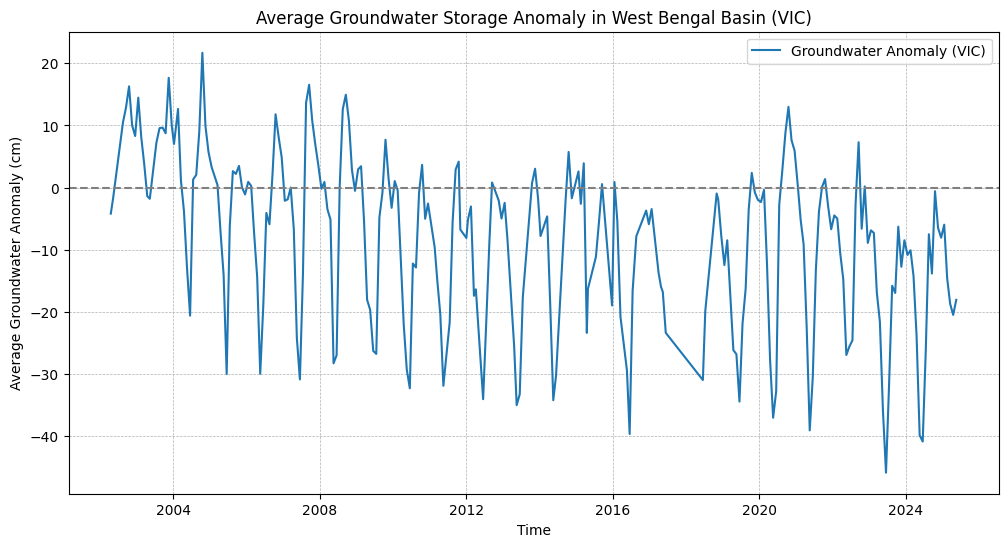

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final file with the per-pixel GWS data (in cm) ---
# THE FIX: Load the correct VIC-based file
final_df = pd.read_csv('VIC_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Select the necessary columns ---
# Use the correct cm-based column name
gws_timeseries = final_df[['time', 'GWS_anomaly_cm']].copy()

# --- Step 3: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = gws_timeseries.groupby('time').mean().reset_index()

# --- Step 4: Create the plot ---
print("Generating the final time-series plot for VIC data...")

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plotting the data
# THE FIX: Update the label for the legend
plt.plot('time', 'GWS_anomaly_cm', data=gws_basin_avg, label='Groundwater Anomaly (VIC)')

# Plotting a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# Adding a title and labels
# THE FIX: Update the plot title
plt.title('Average Groundwater Storage Anomaly in West Bengal Basin (VIC)')
plt.xlabel('Time')
plt.ylabel('Average Groundwater Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.show()

Generating the final discontinuous smooth curve plot...


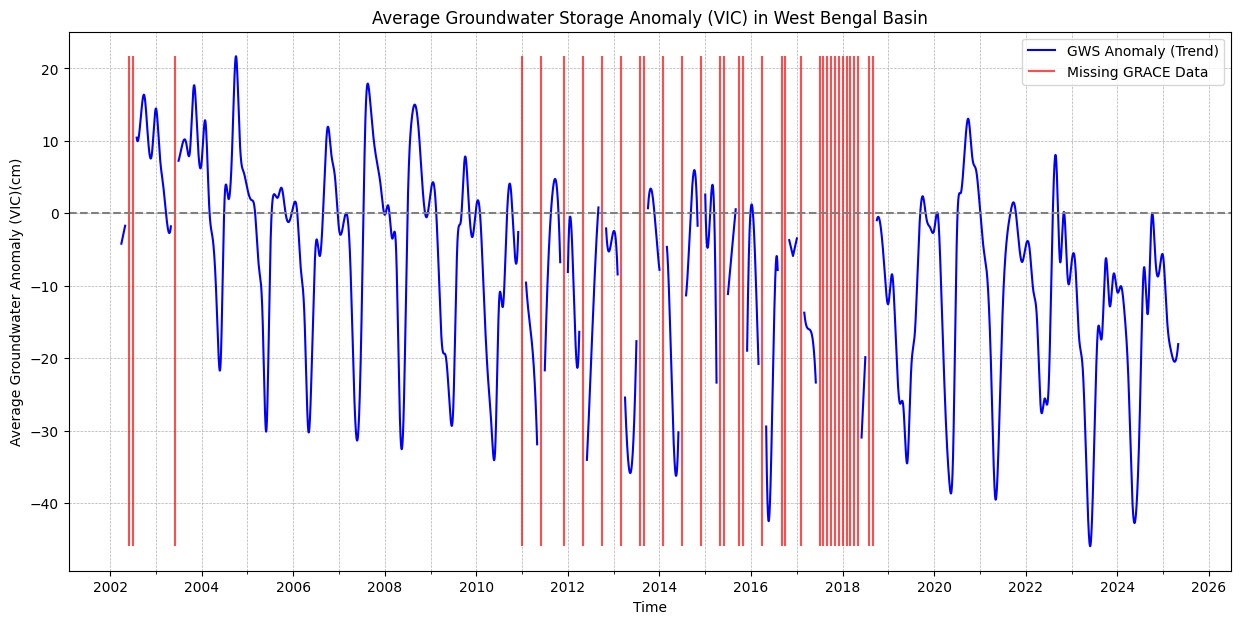

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline

# --- Steps 1-4: Load and prepare the data (these are unchanged) ---
final_df = pd.read_csv('VIC_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

gws_basin_avg = final_df.groupby('time')['GWS_anomaly_cm'].mean().reset_index()

gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(),
    end=gws_basin_avg['time'].max(),
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')


# --- Step 5: Create the discontinuous smooth curve plot ---
print("Generating the final discontinuous smooth curve plot...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# Separate data into points that exist and points that are missing
has_data = plot_df.dropna().sort_values(by='time').drop_duplicates(subset='time')
missing_data = plot_df[plot_df['GWS_anomaly_cm'].isna()]

# --- THE FIX: Identify contiguous blocks of data ---
# A new block is identified where the gap between dates is more than a month
has_data['block'] = (has_data['time'].diff() > pd.Timedelta('32 days')).cumsum()

# Loop through each block and plot it as a separate smooth curve
for block_id, group in has_data.groupby('block'):
    # Spline interpolation needs at least a few points to work
    if len(group) > 3:
        # Convert dates to a numerical format for interpolation
        x_numeric = group['time'].astype(np.int64) // 10**9
        y = group['GWS_anomaly_cm']
        
        spline = CubicSpline(x_numeric, y)
        
        x_numeric_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 100 * len(group))
        x_datetime_smooth = pd.to_datetime(x_numeric_smooth, unit='s')
        
        y_smooth = spline(x_numeric_smooth)
        
        # Use the same color for all segments, but don't repeat the label
        ax.plot(x_datetime_smooth, y_smooth, color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly (Trend)')
    elif len(group) > 1: # If too few points for a spline, draw a straight line
        ax.plot(group['time'], group['GWS_anomaly_cm'], color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly (Trend)')

# --- Plot the missing data as red vertical lines ---
if not missing_data.empty:
    data_min = has_data['GWS_anomaly_cm'].min()
    data_max = has_data['GWS_anomaly_cm'].max()
    ax.vlines(
        missing_data['time'],
        ymin=data_min if pd.notna(data_min) else -1,
        ymax=data_max if pd.notna(data_max) else 1,
        color='red',
        linestyle='-',
        linewidth=1.5,
        alpha=0.7,
        label='Missing GRACE Data'
    )

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--') 
ax.set_title('Average Groundwater Storage Anomaly (VIC) in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly (VIC)(cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Generating the final time-series plot for VIC data...


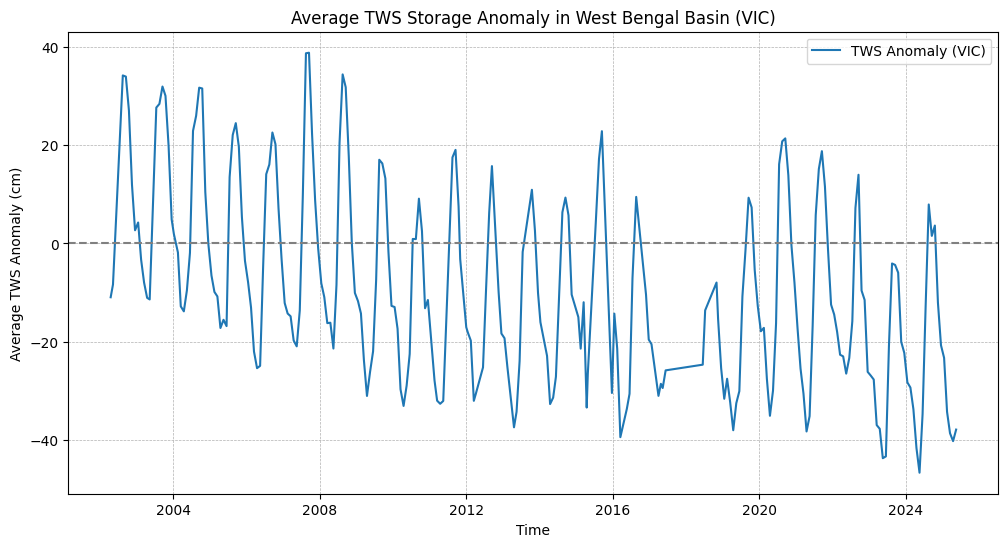

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final file with the per-pixel GWS data (in cm) ---
# THE FIX: Load the correct VIC-based file
final_df = pd.read_csv('VIC_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Select the necessary columns ---
# Use the correct cm-based column name
gws_timeseries = final_df[['time', 'lwe_thickness_cm']].copy()

# --- Step 3: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = gws_timeseries.groupby('time').mean().reset_index()

# --- Step 4: Create the plot ---
print("Generating the final time-series plot for VIC data...")

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plotting the data
# THE FIX: Update the label for the legend
plt.plot('time', 'lwe_thickness_cm', data=gws_basin_avg, label='TWS Anomaly (VIC)')

# Plotting a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# Adding a title and labels
# THE FIX: Update the plot title
plt.title('Average TWS Storage Anomaly in West Bengal Basin (VIC)')
plt.xlabel('Time')
plt.ylabel('Average TWS Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.show()

Loading data to create a map for 2021-11...
Synchronizing and clipping data...
Generating map...


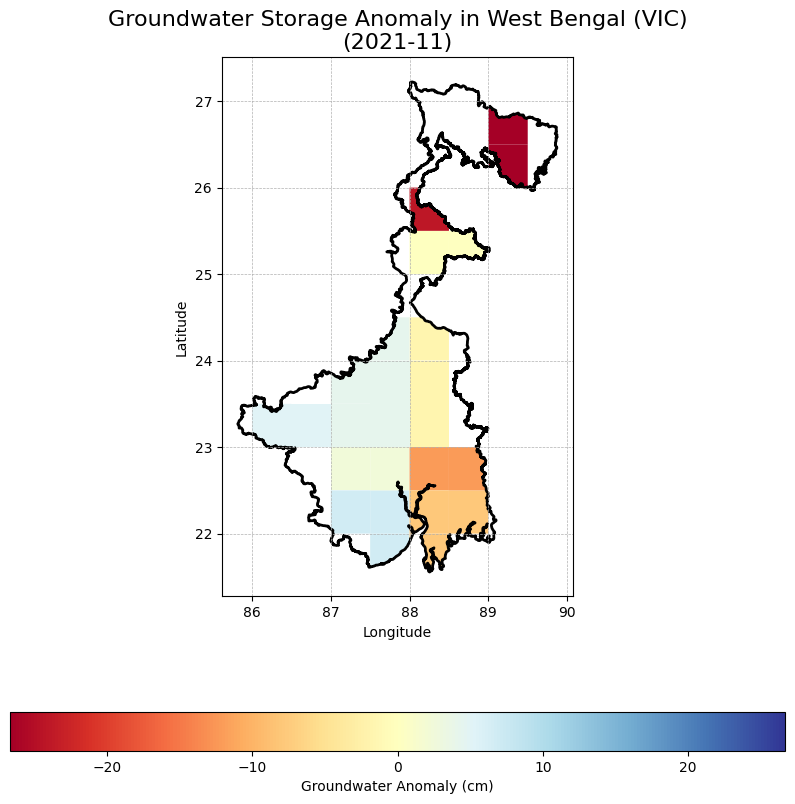

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## --- Configuration ---
year_to_plot = 2021
month_to_plot = 11 

# --- File paths ---
# THE FIX: Load the correct cm-based VIC file
gws_file = 'VIC_GWS_Final_Results_per_Pixel_cm.csv'
shapefile_path = r'D:\Groundwater Vulnerability Mapping\data\shapefiles\West Bengal\West_Bengal.shp'

## --- Step 1: Load Data ---
print(f"Loading data to create a map for {year_to_plot}-{month_to_plot:02d}...")
final_df = pd.read_csv(gws_file)
final_df['time'] = pd.to_datetime(final_df['time'])
basin_shapefile = gpd.read_file(shapefile_path)

## --- Step 2: Filter by Year and Month ---
mask = (final_df['time'].dt.year == year_to_plot) & (final_df['time'].dt.month == month_to_plot)
gws_for_date = final_df[mask].copy()

if gws_for_date.empty:
    print(f"Error: No data found for {year_to_plot}-{month_to_plot:02d}.")
else:
    ## --- Step 3: Prepare Spatial Data (for 0.5° grid) ---
    geometries = []
    for index, row in gws_for_date.iterrows():
        lon, lat = row['lon'], row['lat']
        # Create 0.5 degree polygons
        lon_point_list = [lon - 0.25, lon + 0.25, lon + 0.25, lon - 0.25, lon - 0.25]
        lat_point_list = [lat - 0.25, lat - 0.25, lat + 0.25, lat + 0.25, lat - 0.25]
        geometries.append(Polygon(zip(lon_point_list, lat_point_list)))

    gws_gdf = gpd.GeoDataFrame(gws_for_date, geometry=geometries, crs="EPSG:4326")

    ## --- Step 4: Clip the Data Grid to the Shapefile ---
    print("Synchronizing and clipping data...")
    basin_shapefile = basin_shapefile.to_crs(gws_gdf.crs)
    gws_clipped = gpd.clip(gws_gdf, basin_shapefile)

    ## --- Step 5: Create the Final Map ---
    if gws_clipped.empty:
        print("Error: The clipped dataset is empty.")
    else:
        print("Generating map...")

        v_abs = gws_clipped['GWS_anomaly_cm'].abs().quantile(0.95)
        vmin, vmax = -v_abs, v_abs

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        gws_clipped.plot(column='GWS_anomaly_cm',
                         ax=ax, 
                         legend=True,
                         legend_kwds={'label': "Groundwater Anomaly (cm)", 'orientation': "horizontal"},
                         cmap='RdYlBu', # Red = Below Average, Blue = Above Average
                         vmin=vmin,
                         vmax=vmax)

        basin_shapefile.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

        # THE FIX: Update the plot title to specify VIC
        ax.set_title(f'Groundwater Storage Anomaly in West Bengal (VIC)\n({year_to_plot}-{month_to_plot:02d})', fontsize=16)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, linestyle='--', linewidth=0.5)

        plt.show()